In [1]:
from diffusers import StableDiffusionPipeline, ControlNetModel
import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import cv2
import numpy as np
from google.colab import drive
import kagglehub
import shutil
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

def visualize_tensor(tensor, title=None):
    """
    Visualizes a tensor as an image.

    Args:
        tensor (torch.Tensor or np.ndarray): The tensor to visualize.
        title (str, optional): Title for the image. Defaults to None.
        cmap (str, optional): Colormap for grayscale images. Defaults to 'viridis'.
    """
    # Convert to numpy if input is a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()

    if tensor.shape[0] == 1:  # Grayscale 1xHxW
        tensor = tensor.squeeze(0)  # Remove the channel dimension

    # Handle dimensions
    if len(tensor.shape) == 3 and tensor.shape[0] in [1, 3]:  # CxHxW
        tensor = np.transpose(tensor, (1, 2, 0))  # Convert to HxWxC

    if len(tensor.shape) == 2:
        plt.imshow(tensor)
    elif len(tensor.shape) == 3 and tensor.shape[2] == 3:
        plt.imshow(tensor)
    else:
        raise ValueError("Unsupported tensor shape for visualization")

    # Normalize tensor to 0-1 if necessary
    if tensor.max() > 1.0:
        tensor = tensor / 255.0

    # Display the image
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Mounted at /content/drive


In [2]:
# Load Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
model = pipe.unet

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
class ControlNet(nn.Module):
    def __init__(self, unet, conditioning_channels=3):
        super().__init__()
        self.unet = unet
        # Add a new layer to process the conditioning input
        self.controlnet_cond_embedding = nn.Conv2d(conditioning_channels, unet.config.block_out_channels[0], kernel_size=1)
        # Add a layer to project the concatenated input to 4 channels
        self.projection = nn.Conv2d(unet.config.block_out_channels[0] + 3, 4, kernel_size=1)

    def forward(self, x, timestep, conditioning):
        # Process the conditioning input
        cond_embedding = self.controlnet_cond_embedding(conditioning)
        # Combine the conditioning input with the noisy image
        x = torch.cat([x, cond_embedding], dim=1)
        # Project the concatenated input to 4 channels
        x = self.projection(x)

        print("Input shape to UNet:", x.shape)  # Debugging: Print the input shape

        # Pass through the UNet, passing None for encoder_hidden_states
        return self.unet(x, timestep, encoder_hidden_states=None)

# Create the ControlNet
controlnet = ControlNet(model, conditioning_channels=3).to("cuda")

In [4]:
def preprocess_condition(image):
    # Convert Torch tensor (CxHxW) to numpy array (HWC)
    img_np = image.permute(1, 2, 0).numpy() * 255  # Denormalize if necessary
    img_np = img_np.astype(np.uint8)

    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)

    # Convert back to torch tensor
    edges = torch.from_numpy(edges).float().unsqueeze(0)  # Add channel dimension
    edges = edges.repeat(3, 1, 1)  # Repeat for 3 channels

    return edges

# Dataset and DataLoader
class ControlNetDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.transform = transforms.Compose([transforms.Resize((320, 320)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
                                             ])
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image_path = os.path.join(self.image_dir, img_name)

        # Open image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        condition = preprocess_condition(image)  # Pass the transformed image to preprocess_condition

        # Transform shape from [3, 320, 320] into [4, 320, 320]
        # extra_channel = torch.zeros(1, image.shape[1], image.shape[2])  # Create an extra channel of zeros
        # image = torch.cat((image, extra_channel), dim=0)  # Concatenate along the channel dimension
        # condition = torch.cat((condition, extra_channel), dim=0)

        return {"image": image, "condition": condition}

In [5]:
# Define the target directory for the dataset
celeba_target_dir = os.path.join("/content", "datasets", "celeba")
os.makedirs(celeba_target_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Download the CelebA dataset
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

# Move the dataset to the target directory
for file_or_dir in os.listdir(path):
    src = os.path.join(path, file_or_dir)
    dst = os.path.join(celeba_target_dir, file_or_dir)
    if os.path.isdir(src):
        shutil.move(src, dst)
    else:
        shutil.copy2(src, dst)

print("Dataset successfully downloaded and moved!")
print("Path to dataset files:", celeba_target_dir)

# Optional: List files in the new directory to confirm
celeba_files = os.listdir(celeba_target_dir)
print("Files in dataset directory:", celeba_files)

# Check the contents of the dataset directory
if os.path.exists(celeba_target_dir):
    print("Dataset directory exists!")
    print("Contents of the dataset directory:", os.listdir(celeba_target_dir))
else:
    print("Dataset directory does not exist. Something went wrong!")

image_dir = "/content/datasets/celeba/img_align_celeba/img_align_celeba"

# Create the dataset and dataloader
dataset = ControlNetDataset(image_dir)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

100%|██████████| 1.33G/1.33G [01:01<00:00, 23.1MB/s]

Extracting files...


Dataset successfully downloaded and moved!
Path to dataset files: /content/datasets/celeba
Files in dataset directory: ['list_landmarks_align_celeba.csv', 'list_eval_partition.csv', 'list_bbox_celeba.csv', 'list_attr_celeba.csv', 'img_align_celeba']
Dataset directory exists!
Contents of the dataset directory: ['list_landmarks_align_celeba.csv', 'list_eval_partition.csv', 'list_bbox_celeba.csv', 'list_attr_celeba.csv', 'img_align_celeba']


torch.Size([3, 320, 320])
torch.Size([3, 320, 320])
tensor([[[-0.7176, -0.7176, -0.7176,  ..., -0.7098, -0.7098, -0.7098],
         [-0.7255, -0.7255, -0.7255,  ..., -0.7098, -0.7098, -0.7098],
         [-0.7255, -0.7255, -0.7255,  ..., -0.7098, -0.7098, -0.7098],
         ...,
         [-0.5686, -0.5451, -0.5216,  ..., -0.5922, -0.5922, -0.5922],
         [-0.5529, -0.5373, -0.5216,  ..., -0.5922, -0.5922, -0.5922],
         [-0.5529, -0.5373, -0.5216,  ..., -0.5922, -0.5922, -0.5922]],

        [[-0.7961, -0.7961, -0.7961,  ..., -0.7804, -0.7804, -0.7804],
         [-0.8039, -0.8039, -0.8039,  ..., -0.7804, -0.7804, -0.7804],
         [-0.8039, -0.8039, -0.8039,  ..., -0.7804, -0.7804, -0.7804],
         ...,
         [-0.6392, -0.6157, -0.5922,  ..., -0.6000, -0.6000, -0.6000],
         [-0.6235, -0.6078, -0.5922,  ..., -0.6000, -0.6000, -0.6000],
         [-0.6235, -0.6078, -0.5922,  ..., -0.6000, -0.6000, -0.6000]],

        [[-0.8118, -0.8118, -0.8118,  ..., -0.8196, -0.8196, -0.

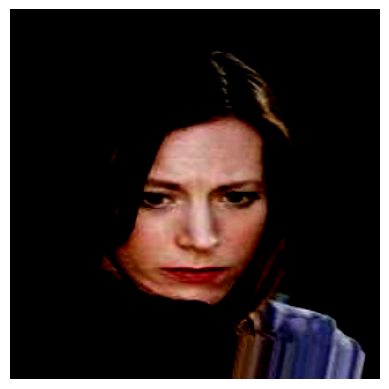

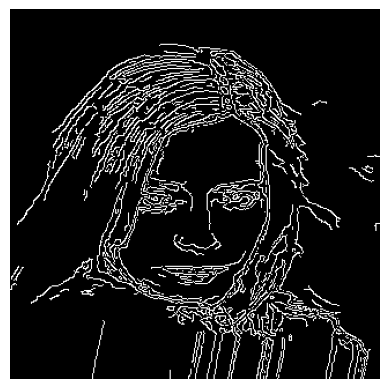

In [6]:
print(dataset[0]['image'].shape)
print(dataset[0]['condition'].shape)
print(dataset[0]['image'])
print(dataset[0]['condition'])
visualize_tensor(dataset[0]['image'])
visualize_tensor(dataset[0]['condition'])

In [7]:
# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(controlnet.parameters(), lr=1e-4)

def train(controlnet, dataloader, optimizer, criterion, epochs, device='cuda', log_interval=10, accumulation_steps=4):
    controlnet.train()  # Set the model to training mode

    for epoch in range(epochs):
        epoch_loss = 0
        tqdm_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

        optimizer.zero_grad()  # Zero the gradients at the start of each epoch

        for step, batch in enumerate(tqdm_bar):
            # Move data to the device (GPU or CPU)
            images = batch['image'].to(device)
            conditions = batch['condition'].to(device)

            # Generate random timesteps (required for diffusion models)
            timesteps = torch.randint(0, 1000, (images.shape[0],), device=device)

            # Forward pass: pass the images, timesteps, and conditions through the ControlNet
            outputs = controlnet(images, timesteps, conditions)

            # Compute the loss between the generated images and the real images
            loss = criterion(outputs.sample, images)
            loss = loss / accumulation_steps  # Normalize the loss

            # Backward pass: compute gradients
            loss.backward()

            # Update the model's parameters every `accumulation_steps` batches
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()  # Zero the gradients after updating

            # Accumulate the loss for logging
            epoch_loss += loss.item()

            # Log the loss every `log_interval` steps
            if step % log_interval == 0:
                tqdm_bar.set_postfix({"loss": loss.item()})

        # Log the average loss for the epoch
        print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {epoch_loss / len(dataloader)}\n")

# Define the number of epochs
epochs = 1

# Start training
train(controlnet, dataloader, optimizer, criterion, epochs, device='cuda')

Epoch 1/1:   0%|          | 0/101300 [00:00<?, ?batch/s]

Input shape to UNet: torch.Size([2, 4, 320, 320])


Epoch 1/1:   0%|          | 0/101300 [00:01<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (204800x320 and 768x320)